In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [4]:
df=pd.read_csv("heart_failure_clinical_records_dataset.csv").copy()

In this work we will predict heart failure. Here is the dataframe that we will work on. If the patient deceased during the follow-up period, it is 1. Otherwise, it is 0.

In [214]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


If we look the information of the columns, we see that there is no null variables.(There is 299 sample and all of the columns have 299 non-null).

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


## DATA ANALYSIS

### Target Variable

The target variable "DEATH_EVENT" has 0 observations more than 1.

In [3]:
print(df["DEATH_EVENT"][df["DEATH_EVENT"]==0].count())
print(df["DEATH_EVENT"][df["DEATH_EVENT"]==1].count())

203
96


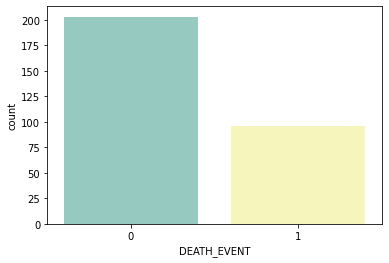

In [18]:
sns.countplot("DEATH_EVENT", data=df, palette="Set3")

### Categorical Variables

We can see in the dataframe,the columns "anaemia", "diabetes", "high_blood_pressure", "sex", "smoking" are categorical variables. Now, we will apply chi-square test for figuring out the association between these variables and target variable. In the result, if p value>0.05 (for alpha = 5%) it means we don't have evidence to believe that there is association between target and that categorical variable. Namely, they are independent. We can ignore that variable because if they dont have any effect on target, keeping them is not useful.

In [5]:
cat_columns=["anaemia","diabetes","high_blood_pressure","sex","smoking"]

In [20]:
import scipy.stats
for i in cat_columns:  
    print("Chi-Square Test Between", "\033[4m", "DEATH_EVENT","\033[0m","and","\033[4m",i,'\033[0m',"\n")
    cross=pd.crosstab(index=df["DEATH_EVENT"], columns=df[i])
    chi2,p,dof,expected= scipy.stats.chi2_contingency(cross)
    print("Chi=", chi2, "\033[1m", "p_value=", p,"\033[0m", "\n")
 

Chi-Square Test Between  DEATH_EVENT  and  anaemia  

Chi= 1.042175485287005  p_value= 0.3073160508415107  

Chi-Square Test Between  DEATH_EVENT  and  diabetes  

Chi= 0.008458101537285573  p_value= 0.9267235137291102  

Chi-Square Test Between  DEATH_EVENT  and  high_blood_pressure  

Chi= 1.5434607612967581  p_value= 0.21410341199416902  

Chi-Square Test Between  DEATH_EVENT  and  sex  

Chi= 0.003037108721613983  p_value= 0.9560508538247334  

Chi-Square Test Between  DEATH_EVENT  and  smoking  

Chi= 0.007331473567119502  p_value= 0.9317652998235507  



All categoric variables has p-value that is greater than 0.05, so we will not use any of them.
We can explain it like this; for example, we take the "diabetes" variable, we find the cross table of it below. 
Look at the numbers, if a sample is not diabete(0), the probability of deadth is 56/174=0.3218.
Otherhand, if the sample is diabete(1), the probability of death is 40/125= 0.32.
So, whether the sample is diabete or not, the probability of dead is equal. So diabete is not effect on the death.

In [9]:
cross=pd.crosstab(index=df["DEATH_EVENT"], columns=df["diabetes"])
print(cross)

diabetes       0   1
DEATH_EVENT         
0            118  85
1             56  40


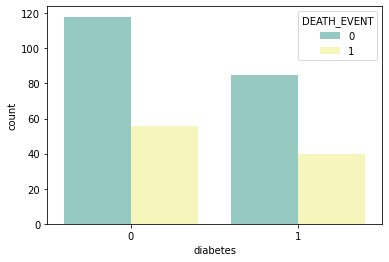

In [10]:
sns.countplot("diabetes", hue="DEATH_EVENT",data=df,palette="Set3")
plt.show()

### Numeric Varibales

Because of the all categorical data has no effect on the target, we will continue with the numeric data.

In [6]:
num_data=df.drop(cat_columns,axis=1)
target=num_data["DEATH_EVENT"]
num_corr=num_data.drop("DEATH_EVENT", axis=1)

#### Correlation Matrix

 First, we will find the correlation in between numeric variables. If there is a any high correlaton (negative or positive) in between two variable, we will use one of them. 
 As you can see in the correlation table there is no high correlation in  between variables. We can use all of them.

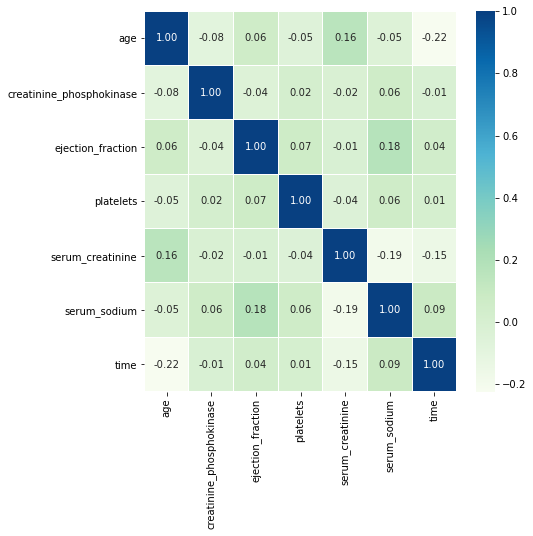

In [24]:
corr=num_corr.corr()
fig,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corr, ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="GnBu")
plt.show()

#### t-test

Now, we will do t-test between numeric variables and target. Result of this will show us the dependence between of them.
In the two sample t-test, null hypotesis, H0, says that "the means of two samples are equal". So, if p-value<0.05, H0 is rejected. It means they have different mean, so there is a meaningful difference between of them. They are dependent. We will eliminate the variables that have p-value>0.05, because they are not dependent on target.

In [25]:
def two_sample_t_test(cl1,cl2, data):
        import scipy.stats as stats
        from pandas import Series
        A=Series(data[cl1].iloc[:][data[cl2]==1])
        B=Series(data[cl1].iloc[:][data[cl2]==0])
        print("\033[1m","'{}' - '{}'". format(cl1,cl2),"\033[0m")
                       
        stat, p=stats.levene(A,B)
       
        if p<0.05:
            var=False
        else:
            var=True
        print("RESULT:")
        stat, p=stats.ttest_ind(A,B, equal_var=var)
        print("\033[1m","p-val=",p,"\033[0m")
        if p<0.05:
            print("\033[1m","H0--> Reject. They have different mean\n","\033[0m")
        else:
            print("\033[1m","H0--> Fail to Reject.\n","\033[0m")

In [26]:
for col in num_data.columns:
    two_sample_t_test(col,"DEATH_EVENT",num_data)

 'age' - 'DEATH_EVENT' 
RESULT:
 p-val= 4.735214517659265e-05 
 H0--> Reject. They have different mean
 
 'creatinine_phosphokinase' - 'DEATH_EVENT' 
RESULT:
 p-val= 0.27961124573614 
 H0--> Fail to Reject.
 
 'ejection_fraction' - 'DEATH_EVENT' 
RESULT:
 p-val= 2.452897418208845e-06 
 H0--> Reject. They have different mean
 
 'platelets' - 'DEATH_EVENT' 
RESULT:
 p-val= 0.3971941540413678 
 H0--> Fail to Reject.
 
 'serum_creatinine' - 'DEATH_EVENT' 
RESULT:
 p-val= 6.398962339971595e-05 
 H0--> Reject. They have different mean
 
 'serum_sodium' - 'DEATH_EVENT' 
RESULT:
 p-val= 0.001872324830123234 
 H0--> Reject. They have different mean
 
 'time' - 'DEATH_EVENT' 
RESULT:
 p-val= 2.3432761217969127e-22 
 H0--> Reject. They have different mean
 
 'DEATH_EVENT' - 'DEATH_EVENT' 
RESULT:
 p-val= 0.0 
 H0--> Reject. They have different mean
 


C:\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In the result of t-test, the variables "creatinine_phosphokinase", "platelets" have p-values greater than 0.05. As you can see in the box plots, for both of the variables, the mean are the same wheter it is dead or not. These variables independent from target. So, we will not use them for model.

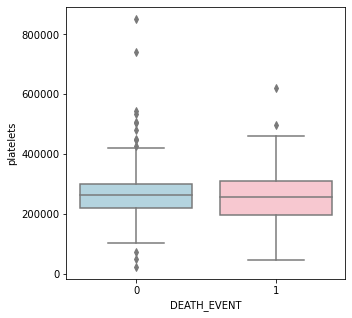

In [33]:
plt.figure(figsize=(5,5))
sns.boxplot(x="DEATH_EVENT",y="platelets", data=df, palette=["lightblue", "pink"])

For example, if we look at the age-dead_event association, we can see that, "DEATH_EVENT" values that are 1, has greater age mean. 

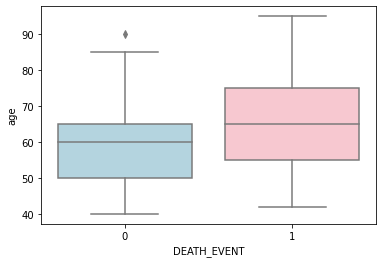

In [34]:
sns.boxplot(x="DEATH_EVENT",y="age", data=df, palette=["lightblue", "pink"])

In [7]:
num_selected=num_data[["age","ejection_fraction","serum_creatinine","serum_sodium","time"]].copy() 
# new numeric data without "creatinine_phosphokinase" and "platelets".

#### Outliers

Now we will look at the outliers. "serum_creatinine" and "serum_sodium" seems like they have a lot of outliers but if we search about these variables, outliers of them are not abnormal values. For example, serum creatinine value is normal value up to 10 mg/dL . This also applies to the serum_sodium variable . So, we will not delete them.

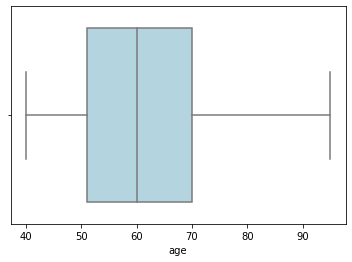

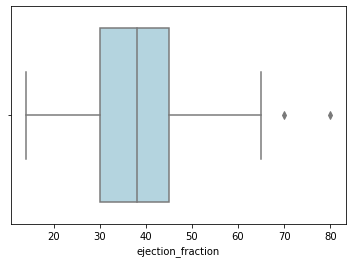

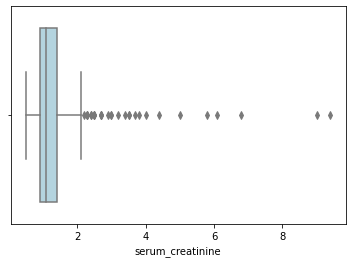

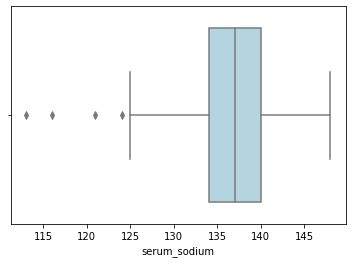

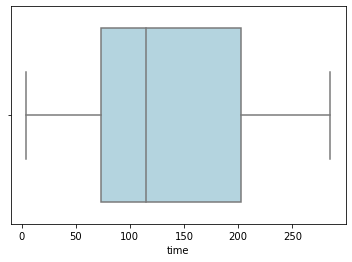

In [35]:
for i in num_selected.columns:
    sns.boxplot(num_selected[i],palette=["lightblue"])   
    plt.show()

#### Train- Test Split

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(num_selected,target,test_size=0.30, random_state=42)

#### Scaling 

Look at the data, the unit of values different. So, we will scale them.

In [36]:
X_train.head()

,age,ejection_fraction,serum_creatinine,serum_sodium,time
225,75.0,60,1.4,125,205
78,75.0,38,0.6,131,74
66,42.0,15,1.3,136,65
296,45.0,60,0.8,138,278
192,50.0,40,0.7,130,175


In [47]:
X_train_scaled=X_train.copy()
X_test_scaled=X_test.copy()

In [48]:
from sklearn.preprocessing import StandardScaler
for i in X_train_scaled.columns:
    scaler=StandardScaler().fit(X_train[[i]])
    X_train_scaled[i]=scaler.transform(X_train[[i]])
    X_test_scaled[i]=scaler.transform(X_test[[i]])

In [12]:
X_train_scaled.head()

,age,ejection_fraction,serum_creatinine,serum_sodium,time
197,0.327183,-0.696584,-0.591832,0.328617,0.670985
210,0.747895,-1.815320,-0.385454,-0.122565,0.696660
288,0.327183,-0.266301,-0.282266,1.230982,1.569607
219,-0.514240,-0.266301,-0.695020,0.779799,0.812197
178,0.158898,1.885114,-0.179077,1.907755,0.170324


After scaling, their units become more regular.

### MODELS

First of all, I will write a method that allows us to access all result information of the models. It will give us train-test scores, cross-validation results and ROC Curves.

In [11]:
def result(model,X_train,X_test,y_train,y_test):
    print( "\033[1m","         ****** RESULT ****** ", "\033[0;0m")
    y_pred = model.predict(X_test)
    print("\033[1m","TEST Accuracy=","\033[0m",accuracy_score(y_test, y_pred))
    print("\033[1m","TEST Report=\n","\033[0m",classification_report(y_test,model.predict(X_test)),"\n")
    y_pred = model.predict(X_train)
    print("\033[1m","TRAIN Accuracy=","\033[0m",accuracy_score(y_train, y_pred))
    print("\033[1m","TRAIN Report=\n","\033[0m",classification_report(y_train,model.predict(X_train)),"\n")
    
    print("\033[1m","Cross Validation TEST:\n","\033[0m",cross_val_score(model, X_test, y_test, cv = 5).mean())    
    print("\033[1m","Cross Validation TRAIN:\n","\033[0m",cross_val_score(model, X_train, y_train, cv = 5).mean(),"\n")
    print("\033[1m","ROC CURVES","\033[0m")
    nb_roc_auc=roc_auc_score(y_test,model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % nb_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive ')
    plt.ylabel('True Positive ')
    plt.title('ROC-TEST')
    plt.show()
    nb_roc_auc=roc_auc_score(y_train,model.predict(X_train))
    fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % nb_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive ')
    plt.ylabel('True Positive ')
    plt.title('ROC-TRAIN')
    plt.show() 
   

#### LOGISTIC REGRESSION

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score

In [39]:
logreg=LogisticRegression()
model=logreg.fit(X_train_scaled,y_train)

          ****** RESULT ******  
 TEST Accuracy=  0.7733333333333333
 TEST Report=
                precision    recall  f1-score   support

           0       0.75      0.93      0.83        44
           1       0.85      0.55      0.67        31

    accuracy                           0.77        75
   macro avg       0.80      0.74      0.75        75
weighted avg       0.79      0.77      0.76        75
 

 TRAIN Accuracy=  0.8571428571428571
 TRAIN Report=
                precision    recall  f1-score   support

           0       0.89      0.91      0.90       159
           1       0.77      0.72      0.75        65

    accuracy                           0.86       224
   macro avg       0.83      0.82      0.82       224
weighted avg       0.86      0.86      0.86       224
 

 Cross Validation TEST:
  0.76
 Cross Validation TRAIN:
  0.847979797979798 

 ROC CURVES 


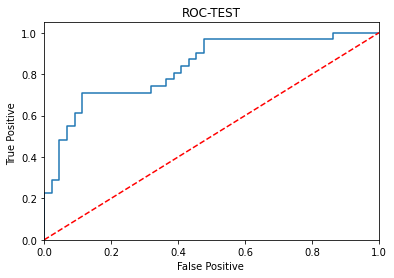

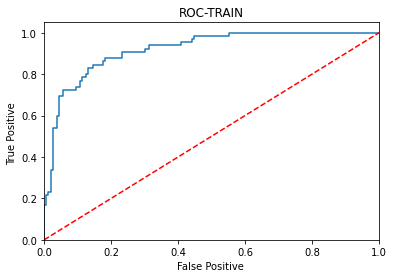

In [40]:
result(logreg,X_train_scaled,X_test_scaled,y_train,y_test)

#### Linear SVC

LinearSVC has no function of predict_proba, so we will use CalibratedClassifierCV for getting probabilities.

In [52]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
svm = LinearSVC()
clf = CalibratedClassifierCV(svm) 
clf.fit(X_train_scaled, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC())

          ****** RESULT ******  
 TEST Accuracy=  0.7777777777777778
 TEST Report=
                precision    recall  f1-score   support

           0       0.75      0.92      0.83        53
           1       0.84      0.57      0.68        37

    accuracy                           0.78        90
   macro avg       0.80      0.75      0.75        90
weighted avg       0.79      0.78      0.77        90
 

 TRAIN Accuracy=  0.8755980861244019
 TRAIN Report=
                precision    recall  f1-score   support

           0       0.89      0.94      0.92       150
           1       0.82      0.71      0.76        59

    accuracy                           0.88       209
   macro avg       0.86      0.83      0.84       209
weighted avg       0.87      0.88      0.87       209
 

 Cross Validation TEST:
  0.7666666666666667
 Cross Validation TRAIN:
  0.8371660859465738 

 ROC CURVES 


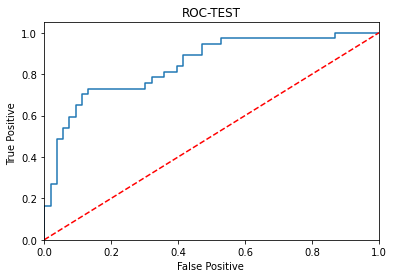

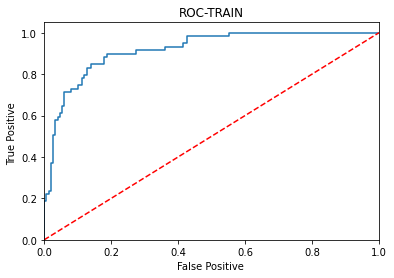

In [53]:
result(clf,X_train_scaled,X_test_scaled,y_train,y_test)

#### NAIVE BAYES

In [49]:
from sklearn.naive_bayes import GaussianNB

In [50]:
nb=GaussianNB().fit(X_train_scaled,y_train)

          ****** RESULT ******  
 TEST Accuracy=  0.7222222222222222
 TEST Report=
                precision    recall  f1-score   support

           0       0.70      0.92      0.80        53
           1       0.80      0.43      0.56        37

    accuracy                           0.72        90
   macro avg       0.75      0.68      0.68        90
weighted avg       0.74      0.72      0.70        90
 

 TRAIN Accuracy=  0.8277511961722488
 TRAIN Report=
                precision    recall  f1-score   support

           0       0.84      0.93      0.89       150
           1       0.77      0.56      0.65        59

    accuracy                           0.83       209
   macro avg       0.81      0.75      0.77       209
weighted avg       0.82      0.83      0.82       209
 

 Cross Validation TEST:
  0.7444444444444445
 Cross Validation TRAIN:
  0.7990708478513356 

 ROC CURVES 


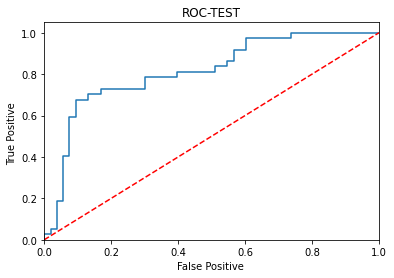

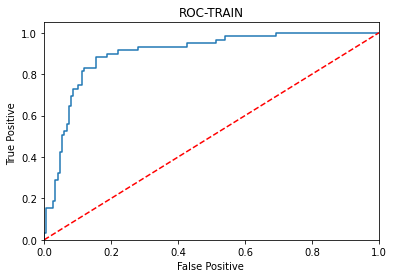

In [51]:
result(nb,X_train_scaled,X_test_scaled,y_train,y_test)

#### SUPPORT VECTOR MACHINES

In [54]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear",probability=True).fit(X_train_scaled, y_train)
svm_model

SVC(kernel='linear', probability=True)

          ****** RESULT ******  
 TEST Accuracy=  0.7777777777777778
 TEST Report=
                precision    recall  f1-score   support

           0       0.76      0.91      0.83        53
           1       0.81      0.59      0.69        37

    accuracy                           0.78        90
   macro avg       0.79      0.75      0.76        90
weighted avg       0.78      0.78      0.77        90
 

 TRAIN Accuracy=  0.8564593301435407
 TRAIN Report=
                precision    recall  f1-score   support

           0       0.90      0.90      0.90       150
           1       0.75      0.75      0.75        59

    accuracy                           0.86       209
   macro avg       0.82      0.82      0.82       209
weighted avg       0.86      0.86      0.86       209
 

 Cross Validation TEST:
  0.788888888888889
 Cross Validation TRAIN:
  0.83739837398374 

 ROC CURVES 


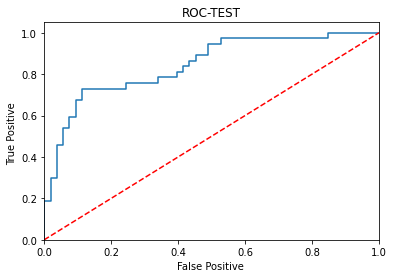

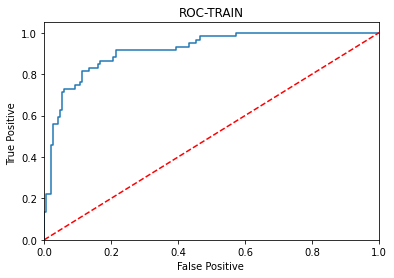

In [55]:
result(svm_model,X_train_scaled,X_test_scaled,y_train,y_test)

#### TUNING

For logistic regression, linear SVC and SVC, the grid search was applied but nothing change. So, this process was not shown. When we look at the train-test accuracy score results, we can see the difference like 0.08, 0.10.. etc. These difference show the the models not enough for the generalization. It can be happened beacuse of our data set size. Logistic regression, linear SVC, SVC perform well when the data set is large; and Naive Bayes performs well when high-dimensional data set. (After feature elimination we had 5 feature and sample size 299 is not large data set.)